# CIFAR-10 with CNN

The CIFAR dataset has 10 different classes contained on RGB images

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time import time


%matplotlib inline

In [2]:
# Setting the transform and getting data
transform = transforms.ToTensor()

# Dataset
path = '../Course Resources/Data/'
train_data = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)

100.0%


Extracting ../Course Resources/Data/cifar-10-python.tar.gz to ../Course Resources/Data/


In [3]:
# Download test data
test_data = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
# Checking the data
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Course Resources/Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

Setting the seed and Data Loaders

In [21]:
# Setting seed
torch.manual_seed(101)
# Deffining Data Loaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
# Setting the class names
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
# Getting a simple batch
for images, labels in train_loader:
    break
labels

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

Label: [3 8 8 0 6 6 1 6 3 1]
Class:  cat ship ship plane frog frog car frog cat car


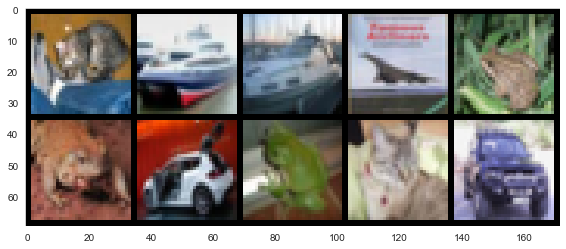

In [15]:
# Getting the labels
print(f'Label: {labels.numpy()}')
print('Class: ', *np.array([class_names[i] for i in labels]))

# Show a sample of images
im = make_grid(images, nrow=5)

# Creating figure
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.grid(False)
plt.show()

---------------

## Creation of the model


In [28]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        '''
        The images are [3, 32, 32] After we do the pooling we will have
        32pix -2 from padding, /2 for the maxpool, -2 for the padding and /2 for maxpooling
        ((((32 - 2) / 2) - 2) / 2)
        '''
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    # Forward
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        # Flattening the output
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)


-------------------

## Loading the model

In [29]:
# Instantiation of the model and setting of seed
# Setting seed
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [30]:
# Check Parameters
total = 0
for param in model.parameters():
    print(param.numel())
    total += param.numel()

print(f'Total parameters: {total}')

450
6
864
16
69120
120
10080
84
840
10
Total parameters: 81590


In [31]:
# Defining criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Training loop
toc = time()

# Trackers
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Training
for i in range(epochs):
    # Tracking for correct answers
    trn_corr = 0
    tst_corr = 0

    # Training
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train) # Not need of flatten as the model takes it full.
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # True / False sum()
        trn_corr += batch_corr

        # Optm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if b%600 == 0:
            print(f'EPOCH: {i}\t\t BATCH: {b}\t\t Loss: {loss.item()}\t\t Acc: {trn_corr.item()*100/(10*b):7.3f}')

    # Saving losses
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test or validaqtion process
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


tic = time()
total = tic - toc
print(f'Training time: {total / 60} mins')

EPOCH: 0		 BATCH: 600		 Loss: 0.7286397814750671		 Acc:  62.083
EPOCH: 0		 BATCH: 1200		 Loss: 1.6320903301239014		 Acc:  62.175
EPOCH: 0		 BATCH: 1800		 Loss: 1.4306827783584595		 Acc:  62.372
EPOCH: 0		 BATCH: 2400		 Loss: 0.9441388249397278		 Acc:  62.288
EPOCH: 0		 BATCH: 3000		 Loss: 0.6234904527664185		 Acc:  62.153
EPOCH: 0		 BATCH: 3600		 Loss: 1.3764939308166504		 Acc:  62.097
EPOCH: 0		 BATCH: 4200		 Loss: 0.6998919248580933		 Acc:  62.210
EPOCH: 0		 BATCH: 4800		 Loss: 0.6478112936019897		 Acc:  62.173
EPOCH: 1		 BATCH: 600		 Loss: 0.8700092434883118		 Acc:  64.100
EPOCH: 1		 BATCH: 1200		 Loss: 1.3105190992355347		 Acc:  63.867
EPOCH: 1		 BATCH: 1800		 Loss: 0.9460917711257935		 Acc:  63.689
EPOCH: 1		 BATCH: 2400		 Loss: 1.1260956525802612		 Acc:  63.475
EPOCH: 1		 BATCH: 3000		 Loss: 1.3763381242752075		 Acc:  63.467
EPOCH: 1		 BATCH: 3600		 Loss: 0.9866083860397339		 Acc:  63.461
EPOCH: 1		 BATCH: 4200		 Loss: 1.7743799686431885		 Acc:  63.469
EPOCH: 1		 BATCH: 4800		 Lo

In [40]:
# Save the model
torch.save(model.state_dict(), '../models/myCIFAR10model.pt')

## Plots

In [41]:
# Data processing
np_train = [x.detach().numpy() for x in train_losses]
np_test = [x.detach().numpy() for x in test_losses]

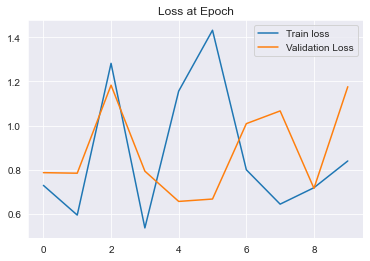

In [53]:
# Matplotlib

plt.plot(np_train, label='Train loss')
plt.plot(np_test, label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()
plt.show()


In [42]:
# Plotly
data = {'Train losses': np_train,
        'Test losses': np_test}
df = pd.DataFrame.from_dict(data)
fig = px.line(df,
              y=['Train losses', 'Test losses'],
              labels={'index': 'Epoch', 'value': 'Loss'},
              title='Losses')
fig.show()

In [43]:
# Printing all corrects
acc = test_correct[-1].item() / len(test_data)
print(f'All accuracy: {acc}')

All accuracy: 0.6131


**Acc plots**

In [46]:
# Processing data
train_acc = [t.detach().numpy()/500 for t in train_correct]
test_acc = [t.detach().numpy()/100 for t in test_correct]

In [47]:
# Plotly
data = {'Train acc': train_acc, 'Test acc': test_acc}
df = pd.DataFrame.from_dict(data)

# Plot
fig = px.line(df, y=['Train acc', 'Test acc'],
              labels={'index': 'Epoch', 'value': 'Loss'},
              title='Accuracy per epoch')

fig.show()

**Testing all data**

In [48]:
# Load all data
test_load_all = DataLoader(test_data, batch_size=10_000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

**Confusion Matrix**

In [49]:
# Seaborn confusion matrix
# Getting the Confusion matrix and store it as a Df
cm = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(cm, class_names, class_names)


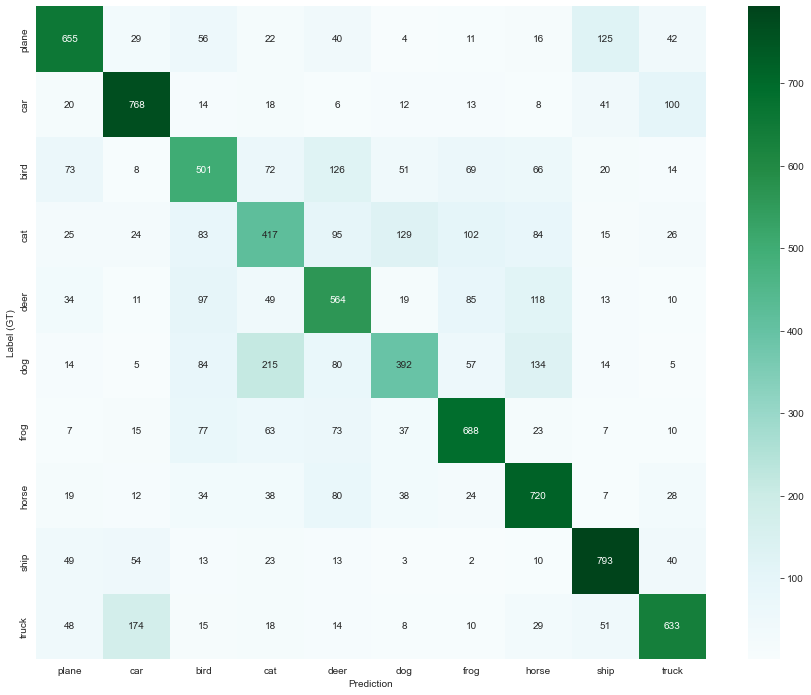

In [52]:
# Creating the plot
plt.figure(figsize=(15, 12))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel('Label (GT)')
plt.show()

In [50]:
# Plotly heatmap
fig = px.imshow(df_cm, text_auto=True)
fig.show()